In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator, interpolant
import torch
import torch.nn as nn
import torch.optim as optim
import time




In [2]:
# Definir a seed
seed = 43
seed2 = 42
seed3 = 42
np.random.seed(seed)

random.seed(seed)


In [3]:
import pandas as pd


def create_interpolation(file_path, decimal=','):

    # Carregar os dados do CSV
    data = pd.read_csv(file_path, decimal=decimal)
    
    # Configurar os eixos da malha
    N_rot = np.arange(2e4, 6e4, 1e3)  # De 20000 rpm a 60000 rpm, Shape: (40,)
    Mass = np.arange(3, 21.1, 0.1)   # De 3 a 21, Shape: (181,)
    Phi = data.values                # Valores da tabela, Shape: (40,181)
    
    # Linearizar a matriz Phi para criação da LUT
    phi_flat = Phi.ravel(order='F')
    
    # Criar a LUT usando interpolação b-spline
    lut = interpolant('name', 'bspline', [N_rot, Mass], phi_flat)
    
    return lut

# Caminho para o arquivo CSV
file_path = r"C:\Users\fabio\Downloads\tabela_phi.csv"

# Chamar a função e obter a LUT
interpolation = create_interpolation(file_path)

N_rot_example = 40412.61691244799
Mass_example = 9.62476391 
result = interpolation([N_rot_example, Mass_example]) 

# Exibir o resultado
print(f"Interpolação para N_rot={N_rot_example}, Mass={Mass_example}: {result}")

Interpolação para N_rot=40412.61691244799, Mass=9.62476391: 1.49599


In [4]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(4500, 5000)  # KPa
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value



class N_generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def N(self):
        while True:
            value = np.random.uniform(4e4, 5e4)  #Hz   # 4e4, 5e4
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value
            



p1_gen = P1Generator(seed)
N_gen = N_generator(seed)

In [5]:
def Nale():
    return np.random.uniform(45e4, 50e3)
def P1():
    return np.random.uniform(4000, 5000)

In [91]:
def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3        # m²
    L_c = 2.0          # m
    alpha = 0.75    #  Constante de Abertura da Valvula
    P_out = 5000       # KPa
    C1 = 479.029       # Constante
    V_p = 2.0          # m³
    K_nu = 0.38 
    0 #0.0765      # kg / (kPa^0.5 s)
    phi = interpolation([45000, x[0]]).__float__() 

    z = 0 if x[1] < P_out else np.sqrt(x[1]   - P_out)

    dmdt = (A1 / L_c) * (phi * 4500 - x[1])*1000 
    dPdt = (C1**2/V_p) * (x[0] - alpha * K_nu * sqrt(x[1] - P_out))/1000
    return [dmdt, dPdt]

stati = fsolve(Estacionario, [10, 9e3])

print(stati,Estacionario(stati))

[  12.4663472  6913.32487013] [np.float64(-1.871649146778509e-09), np.float64(2.5476152614278825e-11)]


In [134]:
def Sistemas(x0, P1_value, interpolant_function, N_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p',2)
    start = time.time()

    #N = p[1]
    phi = interpolant_function(vertcat(p[1], x[0]))  
    
    # Constantes
    A1 = 2.6e-3          # m²
    L_c = 2.0            # m
    alpha = 0.75        # Constante Abertura da valvula
    P_out = 5000         #  kPa
    C1 = 479.029         # Constante Velocidade do Som na Entrada do Compressor 
    V_p = 2.0            # m³
    K_nu = 0.38          # kg / (kPa^0.5 s)
    phi_value = 1.5      # 

    z = if_else(x[1] < P_out, 0, sqrt(x[1] - P_out))
    non = if_else(phi<0,phi+1,phi)
    
    rhs = vertcat(
        (A1 / L_c) * ( non* p[0] - x[1] )*1000,                                     # Vazão Massica/ dt
        (C1**2 / V_p) * (x[0] - alpha* K_nu * sqrt(x[1] - P_out))/1000                             # Pressão do Plenum / dt
    ) 

    ode = {'x': x, 'ode': rhs , 'p': p}
    
    F = integrator('F', 'idas', ode, {'tf': 0.5})

    #
    t_eval = np.linspace(0, 60,)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9
    sol[0,:] = x0
    #
    print(P1_value, N_value)
    for i in range(len(t_eval)-1):
        param = [P1_value, N_value]
        res = F(x0=x0, p=param)
        x_next = res['xf'].full().flatten()
        sol[i+1] = x_next
        # Update initial state
        x0 = x_next

    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    
    return sol, P1_value,N_value, t_eval
    


In [8]:
def Loop(loops, stati):
    estados = []
    p1_total = []
    N_total = []
    t_eval_total = []
    for i in range(loops):
        if i == 0:
            x0 = stati  # Estado inicial
        else:
            x0 = estados[-1][-1]
        print(x0)
        P1_v = p1_gen.P1()  # Geração aleatória de P1
        N_v = N_gen.N()
        sol, P1_aleatorio,aaaa, t_eval = Sistemas(x0, P1_v, interpolation, N_v)
        estados.append(sol)
        N_total.append(aaaa)
        p1_total.append(P1_aleatorio)
        
        # Concatenar tempo
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, N_total, t_total

[  12.4663472  6913.32487013]
4821.637495381577 40737.93809631771
Tempo de execução: 0.02515697479248047 segundos
[  11.63367807 6666.26614613]
4892.172380963651 42621.68529404257
Tempo de execução: 0.024313926696777344 segundos
[  12.40538319 6894.65710124]
4890.377601570176 46670.957768103835
Tempo de execução: 0.0406801700592041 segundos
[  13.80844352 7347.46696449]
4738.871888697858 40693.033711414806
Tempo de execução: 0.04339790344238281 segundos
[  11.45234037 6614.72580159]
4794.986552695193 40260.809413195246
Tempo de execução: 0.04002523422241211 segundos
[  11.41927162 6605.41415069]
4905.7358494129385 47366.5457958381
Tempo de execução: 0.036624908447265625 segundos
[  14.07967234 7440.58966742]
4773.0326852699945 46467.30727729211
Tempo de execução: 0.02540111541748047 segundos
[  13.53513966 7255.46357746]
4578.215861465414 46328.442157368
Tempo de execução: 0.020400524139404297 segundos
[  13.1154562  7117.76173365]
4660.763222368757 45652.92404124211
Tempo de execução:

C:\Users\fabio\AppData\Local\Temp\ipykernel_29652\1333400074.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\fabio\AppData\Local\Temp\ipykernel_29652\1333400074.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


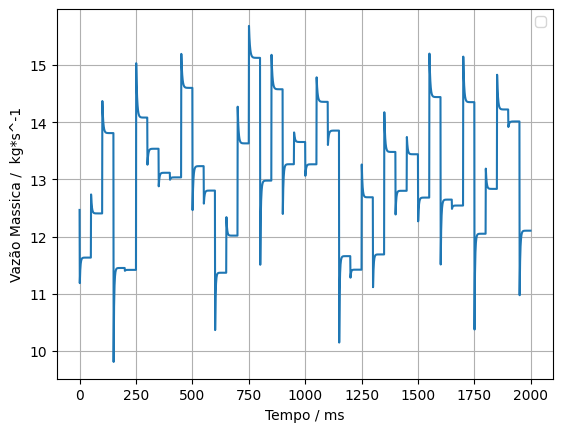

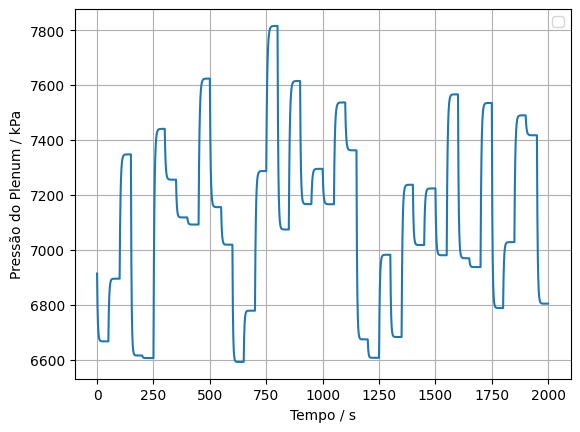

In [170]:

aaaa, PlotP1, PlotN, Plott = Loop(40, stati)
bbb = aaaa
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]

P_p_final = Ploty[:,1]

# Plotar os resultados
plt.figure()
plt.plot(Ploty[:, 0])
plt.xlabel('Tempo / ms')
plt.ylabel('Vazão Massica /  kg*s^-1')


plt.legend()
plt.grid(True)
plt.figure()
plt.plot(Ploty[:, 1])
plt.xlabel('Tempo / s')
plt.ylabel('Pressão do Plenum / kPa')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()



In [171]:
# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
N_values = np.array(PlotN)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]

# Garantindo que as repetições sejam suficientes
repeated_P1 = np.repeat(P1_values, -(-len(M[:-1]) // len(P1_values)))[:len(M[:-1])]
repeated_N = np.repeat(N_values, -(-len(M[:-1]) // len(N_values)))[:len(M[:-1])]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], repeated_P1, repeated_N))
y = np.column_stack((M[1:], P_p[1:]))

split_index = len(X) // 2

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [172]:
# Normalização de dados para o intervalo [-1, 1]
def normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = 2 * (Mat_dados[:, i] - min_value) / (max_value - min_value) - 1
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = 2 * (Mat_dados[:] - min_value) / (max_value - min_value) - 1

    return result


# Desnormalização de dados do intervalo [-1, 1] para os valores originais
def des_normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] + 1) * (max_value - min_value) / 2 + min_value


    return result





# Normalização de dados para as redes.
def zero_normalize(Mat_ref,Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
                max_value = Mat_ref[:,i].max()
                min_value = Mat_ref[:,i].min()
                result[:,i] = (Mat_dados[:,i] - min_value) / (max_value - min_value)
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] - min_value) / (max_value - min_value)

    return result
# Desnormalização de dados para as redes.
def zero_des_normalize(Mat_ref,Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:,i].max()
            min_value = Mat_ref[:,i].min()
            result[:,i] = (Mat_dados[:,i] ) * (max_value - min_value) + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] ) * (max_value - min_value) + min_value

    return result

In [173]:
X_test_ref = X_test
y_test_ref = y_test
X_train = normalize(X_train,X_train)
X_test =   normalize(X_test,X_test)
y_train = normalize(y_train,y_train)
y_test =   normalize(y_test,y_test)

# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Adiciona dimensão de sequência
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [13]:
         # Camadas lineares
        #self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # 2*hidden_dim por ser bidirecional
        #self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        #self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        #self.fc4 = nn.Linear(hidden_dim // 2, output_dim)

In [174]:

# Modelo em PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.activation = nn.Tanh()
        #self.activation = nn.Sigmoid()
        self
        self.fc = nn.Linear(hidden_dim * 2,hidden_dim )  # 2*hidden_dim por ser bidirecional
        self.activation = nn.Tanh()
        self.fc1 = nn.Linear(hidden_dim , hidden_dim//2,) 
        self.fc2 = nn.Linear(hidden_dim//2 , output_dim)  # 2*hidden_dim por ser bidirecional

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.transpose(0, 1).reshape(-1, h_n.size(2) * 2)  # Concatenar saídas bidirecionais

        x = self.dropout(h_n)
        x = self.activation(self.fc(x))
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [189]:
X_train_tensor.shape[0]//20


49

In [190]:
# Definir parâmetros do modelo
input_dim = X_train_tensor.shape[2]

output_dim = y_train_tensor.shape[1]

# Treinamento do modelo
n_epochs = 1000 
batch_size = 32
early_stop_patience = 180

train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)




In [176]:
import optuna 
from optuna.trial import TrialState

def objective(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    hidden_dim = trial.suggest_int("hidden_dim",   30, 60)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    return loss.item()



In [18]:

# Rodar a otimização com Optuna
study = optuna.create_study(direction='minimize') #sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize



[I 2024-12-06 12:39:48,326] A new study created in memory with name: no-name-738dd463-b282-4f06-9e6e-7f98e8fbf7e1


<bound method Study.optimize of <optuna.study.study.Study object at 0x000001763B1FB150>>

In [179]:
study.optimize(objective, n_trials=5)
# Imprimir o melhor conjunto de hiperparâmetros
print(study.best_params)

[I 2024-12-06 12:53:44,836] Trial 1 finished with value: 0.001441018539480865 and parameters: {'dropout_rate': 0.2696741251643109, 'hidden_dim': 38, 'learning_rate': 1.1100237884068301e-05}. Best is trial 1 with value: 0.001441018539480865.
[I 2024-12-06 13:05:50,638] Trial 2 finished with value: 7.249131886055693e-05 and parameters: {'dropout_rate': 0.17516956263512368, 'hidden_dim': 41, 'learning_rate': 0.000338020561604931}. Best is trial 2 with value: 7.249131886055693e-05.
[W 2024-12-06 13:06:32,556] Trial 3 failed with parameters: {'dropout_rate': 0.17959481591628607, 'hidden_dim': 57, 'learning_rate': 0.00018619763154329274} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\fabio\AppData\Local\Temp\ipykernel_29652\3132943349.py

KeyboardInterrupt: 

In [ ]:
#[I 2024-12-06 13:05:50,638] Trial 2 finished with value: 7.249131886055693e-05 and parameters: {'dropout_rate': 0.17516956263512368, 'hidden_dim': 41, 'learning_rate': 0.000338020561604931}. Best is trial 2 with value: 7.249131886055693e-05.


C:\Users\fabio\AppData\Local\Temp\ipykernel_33220\3850076208.py:2: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

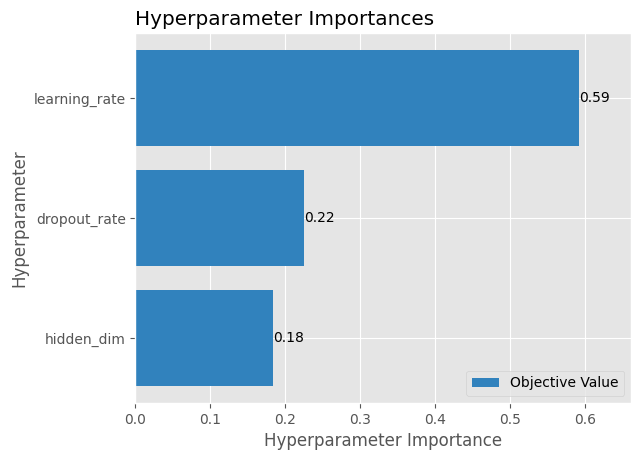

In [ ]:
from plotly.io import show
optuna.visualization.matplotlib.plot_param_importances(study)

In [ ]:
best_params = study.best_params
# Definir parâmetros do modelo
hidden_dim = best_params['hidden_dim']  
dropout_rate =  best_params['dropout_rate']
learning_rate = best_params['learning_rate']

# Inicializar o modelo, função de perda e otimizador
model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(best_params)


# Para armazenar as perdas de treino e validação
train_losses = []
val_losses = []
best_loss = float('inf')
patience = 30



model.train()
for epoch in range(2000):
    batch_train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.item())
    
    # Perda média do treino na época atual
    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)
    
    model.eval()
    with torch.no_grad():
        batch_val_losses = [criterion(model(X_val), y_val).item() for X_val, y_val in test_loader]
        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        if patience >= early_stop_patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Carregar o melhor modelo salvo
model.load_state_dict(best_model)



{'dropout_rate': 0.17516956263512368, 'hidden_dim': 41, 'learning_rate': 0.000338020561604931}
Epoch 1/1000, Train Loss: 0.2221310278546298, Val Loss: 0.2634293451519625


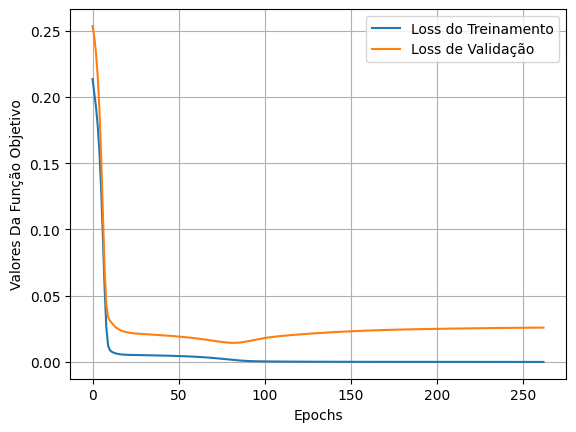

In [181]:
plt.plot(train_losses, label='Loss do Treinamento')
plt.plot(val_losses, label='Loss de Validação')
#plt.plot(history.history['val_loss'], label='Validation Loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Valores Da Função Objetivo')
plt.grid()
plt.show()

In [182]:
# Carregar o melhor modelo salvo

model.load_state_dict(best_model)
tempos = []

# Avaliação final com o conjunto de teste
model.eval()



LSTMModel(
  (lstm): LSTM(4, 41, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.17516956263512368, inplace=False)
  (activation): Tanh()
  (fc): Linear(in_features=82, out_features=41, bias=True)
  (fc1): Linear(in_features=41, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)

In [ ]:

with torch.no_grad():

    for i in range (10000):
        start = time.time()
        y_test_pred = model(X_test_tensor)
        end = time.time()
        print(f"Tempo de execução: {end - start} segundos")
        test_loss = criterion(y_test_pred, y_test_tensor)
        tempo = end - start
        tempos.append(tempo)
        #print(f"Teste Loss: {test_loss.item()}")


In [ ]:
import seaborn as sns
default_dpi = 96
time_x = np.arange(len(tempos))
tempos = tempos
print(tempos)
def save_or_show(filename: str | None = None):
    if filename is None:
        plt.show()
    else:
        plt.savefig(save_folder + filename)
        plt.clf()
        plt.close()

In [ ]:
def plot_density(values, labels, metric, filename: str | None = None):
    plt.figure(figsize=(10, 4), layout="constrained", dpi=default_dpi)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    for i in range(len(values)):
        sns.histplot(
            values[i],
            kde=True,
            label=labels[i],
            stat="density",
            bins=100,
            color=colors[i],
        )

        mean_value = np.mean(values[i])
        plt.axvline(
            mean_value,
            linestyle="--",
            linewidth=1.5,
            color=colors[i],
        )

    plt.xlabel(metric)
    plt.xlim(0.12, max(values[0]))
    plt.ylabel("Densidade de Probabilidade")
    plt.grid()
    plt.legend()

plot_density([tempos], ["Tempo de Execução"], "Tempo de Execução/s")

Tempo de execução: 0.010233879089355469 segundos


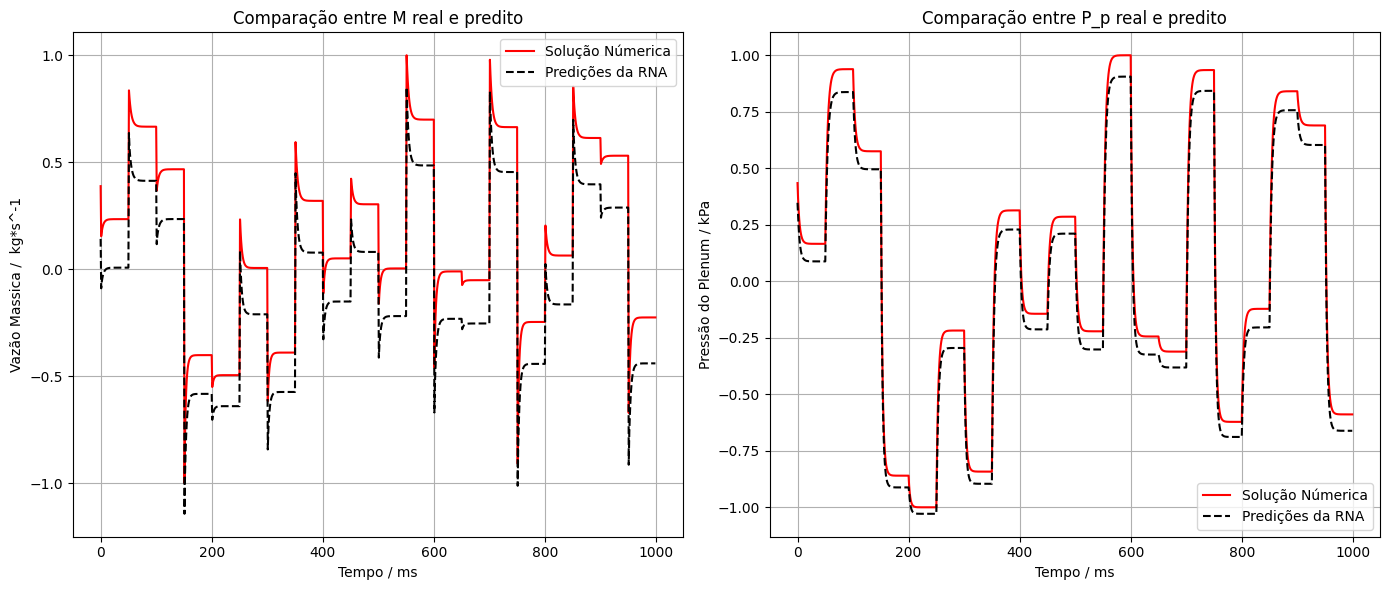

In [191]:
mse = nn.MSELoss()



with torch.no_grad():
    start = time.time()
    y_test_pred = model(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = mse(y_test_pred, y_test_tensor)


y_test_pred_original =  y_test_pred
y_test_original = y_test


plt.figure(figsize=(14, 6))

# Plot para M (Mass Flow Rate)
plt.subplot(1, 2, 1)
plt.plot(y_test_original[:, 0], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 0], "--", label="Predições da RNA", color="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Vazão Massica /  kg*s^-1')
plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.subplot(1, 2, 2)
plt.plot(y_test_original[:, 1], label="Solução Númerica" ,color="red")
plt.plot(y_test_pred_original[:, 1], "--", label="Predições da RNA", color
         ="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Pressão do Plenum / kPa')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()


Tempo de execução: 0.007607698440551758 segundos
Perda de teste (MSE): 0.025957031175494194
Deslocamento aplicado:
[0.21316068 0.07494763]


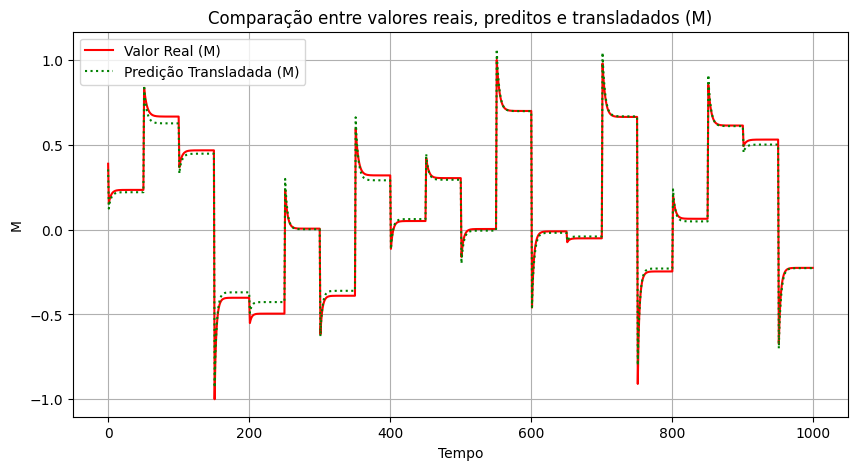

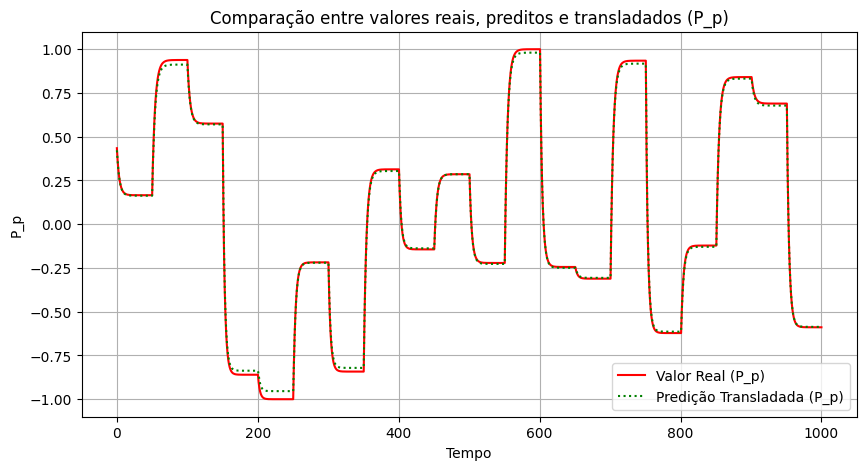

In [185]:
import torch
import numpy as np

# Função de perda (já definida no seu código)
mse = torch.nn.MSELoss()

# Predição sem gradiente
with torch.no_grad():
    start = time.time()
    y_test_pred = model(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    
    # Cálculo da perda de teste
    test_loss = mse(y_test_pred, y_test_tensor)
    print(f"Perda de teste (MSE): {test_loss.item()}")

# Convertendo tensores para arrays numpy para manipulação
y_test_pred_numpy = y_test_pred.numpy()
y_test_numpy = y_test_tensor.numpy()

# Cálculo do deslocamento médio (método de translação simples)
deslocamento = np.mean(y_test_numpy - y_test_pred_numpy, axis=0)

# Aplicando o deslocamento às predições
y_test_pred_transladado = y_test_pred_numpy + deslocamento

# Converta os valores ajustados de volta para tensores (se necessário para uso posterior)
y_test_pred_transladado_tensor = torch.tensor(y_test_pred_transladado)

# Comparação original e ajustado
print("Deslocamento aplicado:")
print(deslocamento)

# Plotando os resultados
import matplotlib.pyplot as plt

tempo = np.linspace(0, len(y_test_numpy), len(y_test_numpy))  # Ajuste conforme necessário

# Para o primeiro parâmetro (M)
plt.figure(figsize=(10, 5))
plt.plot(tempo, y_test_numpy[:, 0], label="Valor Real (M)", color="red")
#plt.plot(tempo, y_test_pred_numpy[:, 0], label="Predição Original (M)", color="blue", linestyle="--")
plt.plot(tempo, y_test_pred_transladado[:, 0], label="Predição Transladada (M)", color="green", linestyle=":")
plt.xlabel("Tempo")
plt.ylabel("M")
plt.legend()
plt.title("Comparação entre valores reais, preditos e transladados (M)")
plt.grid()
plt.show()

# Para o segundo parâmetro (P_p)
plt.figure(figsize=(10, 5))
plt.plot(tempo, y_test_numpy[:, 1], label="Valor Real (P_p)", color="red")
#plt.plot(tempo, y_test_pred_numpy[:, 1], label="Predição Original (P_p)", color="blue", linestyle="--")
plt.plot(tempo, y_test_pred_transladado[:, 1], label="Predição Transladada (P_p)", color="green", linestyle=":")
plt.xlabel("Tempo")
plt.ylabel("P_p")
plt.legend()
plt.title("Comparação entre valores reais, preditos e transladados (P_p)")
plt.grid()
plt.show()


In [ ]:
#torch.save(model, r"C:\Users\fabio\PycharmProjects\PRH-1\model\model22222222.pth")

In [ ]:
model_load1 = torch.load(r"C:\Users\fabio\PycharmProjects\PRH-1\model\model1111111111.pth")




Tempo de execução: 0.019427061080932617 segundos


C:\Users\fabio\AppData\Local\Temp\ipykernel_29652\624954811.py:25: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value


<Figure size 3000x100 with 0 Axes>

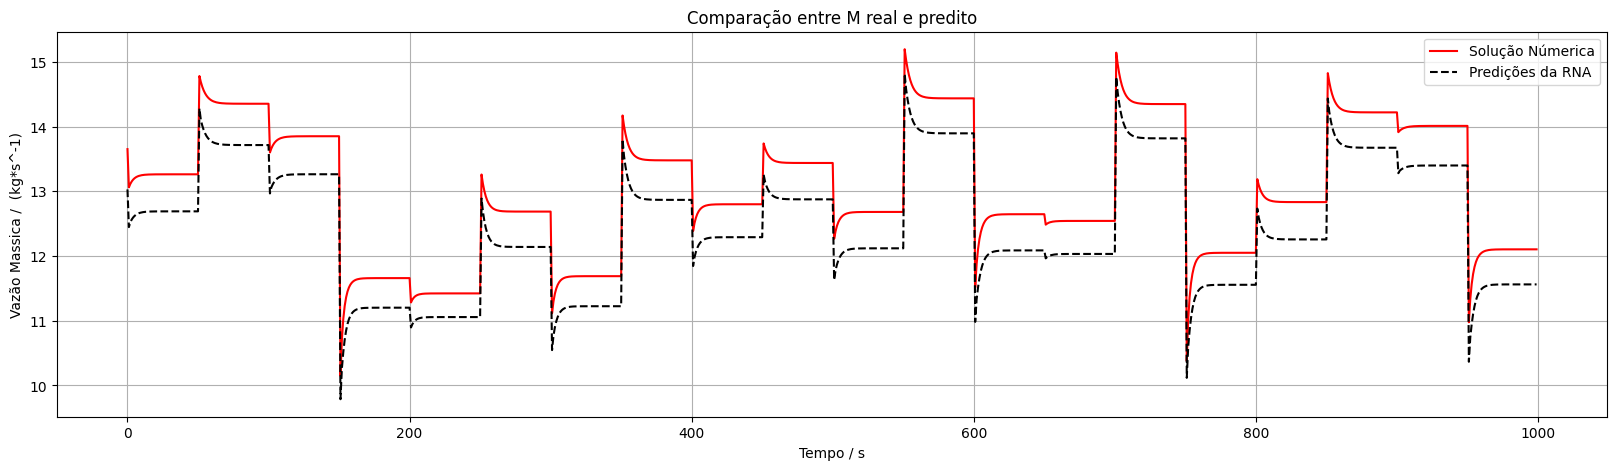

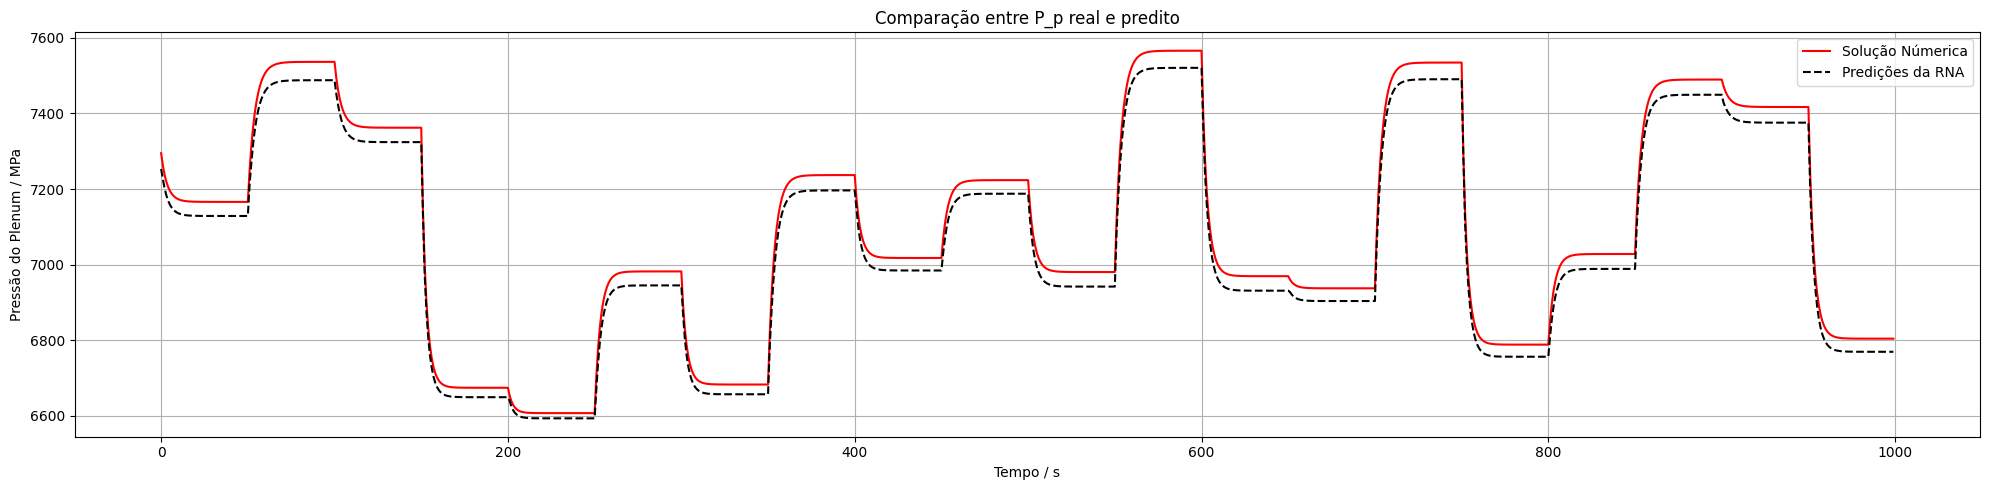

In [186]:
mse = nn.MSELoss()



with torch.no_grad():
    start = time.time()
    y_test_pred = model(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = mse(y_test_pred, y_test_tensor)


y_test_pred_original = des_normalize(y_test_ref, y_test_pred)
y_test_original = des_normalize(y_test_ref,y_test)

plt.figure(figsize=(30, 1))

# Plot para M (Mass Flow Rate)
plt.figure(figsize=(20, 5))
plt.plot(y_test_original[:, 0], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 0], "--", label="Predições da RNA", color="black")
plt.xlabel('Tempo / s')
plt.ylabel('Vazão Massica /  (kg*s^-1)')
plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.figure(figsize=(20, 5))
plt.plot(y_test_original[:, 1], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 1], "--", label="Predições da RNA", color="black")
plt.xlabel('Tempo / s')
plt.ylabel('Pressão do Plenum / MPa')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()